In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [2]:
vgg = torchvision.models.vgg19(pretrained=True)
network = vgg.features.eval().to(device)
image_size = 1024
style_name = 'The_Scream.jpg'
src_name = 'domashka.jpg'

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()])

def plot_image(image, title):
    plt.figure()
    plt.imshow(image)
    plt.title(title)

In [4]:
def get_input_optimizer(input_img):
    optimizer = torch.optim.LBFGS([input_img.requires_grad_()])
    return optimizer

class TorchNorm(nn.Module):
    def __init__(self):
        super(TorchNorm, self).__init__()
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406], device=device).view(1, -1, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225], device=device).view(1, -1, 1, 1))

    def forward(self, img):
        return (img - self.mean) / self.std

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleCache(nn.Module):
    def __init__(self, target_feature):
        super(StyleCache, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

class SrcCache(nn.Module):
    def __init__(self, target,):
        super(SrcCache, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [5]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def create_transfer_model(cnn, style_tensor, src_tensor, content_layers = content_layers_default, style_layers = style_layers_default):
    contents = []
    styles = []
    model = nn.Sequential(TorchNorm())

    layers = {}
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            type = 'conv'
        elif isinstance(layer, nn.ReLU):
            type = 'relu'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            type = 'pool'
        elif isinstance(layer, nn.BatchNorm2d):
            type = 'batch'
        else:
            raise RuntimeError(f'Unknown layer type')

        id = layers[type] = layers.setdefault(type, 0) + 1
        name = f'{type}_{id}'
        model.add_module(name, layer)

        if name in content_layers:
            cache = SrcCache(model(src_tensor))
            model.add_module(f'src_{name}', cache)
            contents.append(cache)

        if name in style_layers:
            cache = StyleCache(model(style_tensor))
            model.add_module(f'style_{name}', cache)
            styles.append(cache)

        if len(content_layers) == len(contents) and len(style_layers) == len(styles):
            break

    return model, styles, contents

In [6]:
def run_style_transfer(cnn, src_tensor, style_tensor, input_tensor, epochs=300,
                       style_weight=100000, content_weight=1):
    print('Building the style transfer model..')
    model, style_layers, src_layers = create_transfer_model(cnn, style_tensor, src_tensor)
    optimizer = get_input_optimizer(input_tensor)

    print('Optimizing..')
    epoch = [0]
    def closure():
        input_tensor.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_tensor)
        style_loss = 0
        content_loss = 0

        for layer in style_layers:
            style_loss += layer.loss
        for layer in src_layers:
            content_loss += layer.loss

        style_loss *= style_weight
        content_loss *= content_weight

        loss = style_loss + content_loss
        loss.backward()

        epoch[0] += 1
        print(f'\rEpoch {epoch[0]}, style loss {style_loss.item()}, content loss {content_loss.item()}', end='')

        return loss

    while epoch[0] <= epochs:
        optimizer.step(closure)

    input_tensor.data.clamp_(0, 1)
    return input_tensor

Building the style transfer model..
Optimizing..
Epoch 320, style loss 1.153459072113037, content loss 5.56046247482299895

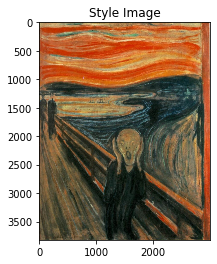

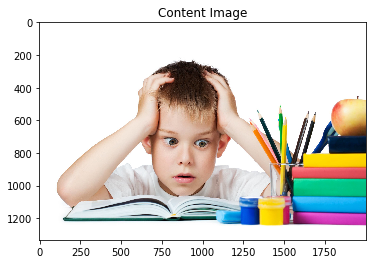

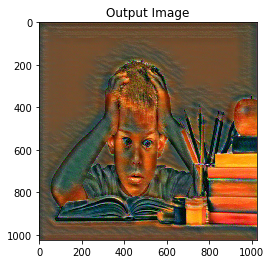

In [7]:
style_image = Image.open(style_name)
src_image = Image.open(src_name)

style_tensor = preprocess(style_image).unsqueeze(0).to(device)
src_tensor = preprocess(src_image).unsqueeze(0).to(device)

plt.ion()
plot_image(style_image, 'Style Image')
plot_image(src_image, 'Content Image')

input_tensor = src_tensor.clone()
output = run_style_transfer(network, src_tensor, style_tensor, input_tensor)

output_image = transforms.ToPILImage()(output.cpu().squeeze(0))
plot_image(output_image, 'Output Image')

plt.ioff()
plt.show()
